In [1]:
import pandas as pd 
import numpy as np 
from os.path import join as os_join
import json
import pprint
import matplotlib.pyplot as plt
import pickle
pp = pprint.PrettyPrinter(width=41, compact=True)
# white, professional/manager, US vs non-US, workclass (gov vs private)


# 0. Model input:
```
x = [age_feat, edu_feat, hours_per_week_feat, sex_feat, race_white_black_feat, country_is_native_feat, occupation_managerial_feat, occupation_is_gov_feat]
y = [ is_greater_than_50K ]
```

```
age             :       normalized to [0,1], original max: 90 , original min: 17
edu_num         :       normalized to [0,1], original max: 16 , original min: 1
hours_per_week  :       normalized to [0,1], original max: 99 , original min: 1
is_male         : 1.0 means male, 0.0 means female,
race-related:   : 1.0 means black, 0.0 means white,
native_immigrant: 1.0 means American, 0.0 means not,
managerial_feat : 1.0 means management job, 0.0 means not,
gov_feat        : 1.0 means government job,

is_greater_than_50K: Binary indictor

```



# 1. Data distribution

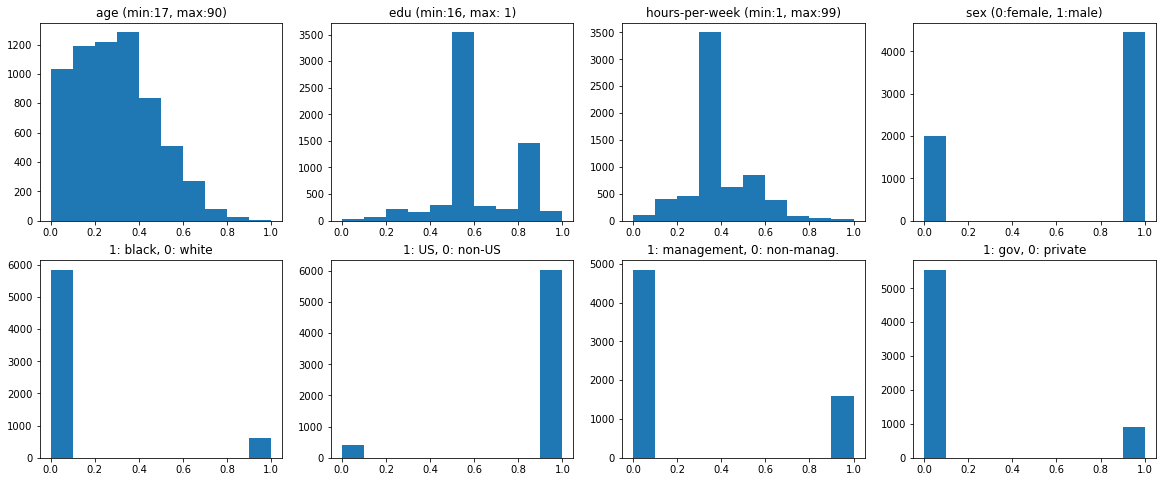

In [2]:
    
cache_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/cache'
random_seed = 0
cache_file_path = os_join(cache_path,f'np-adult-data-v2-rs={random_seed}.pkl')
with open(cache_file_path, 'rb') as f:
    data_dict = pickle.load(f)
X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_dev = data_dict["X_dev"]
y_dev = data_dict["y_dev"]
X_test = data_dict["X_test"]
y_test = data_dict["y_test"]
input_shape = X_train.shape[1]

# testing data distribution:
age_feat = (X_test[:,0],'age (min:17, max:90)')
edu_feat = (X_test[:,1],'edu (min:16, max: 1)')
hours_wk_feat = (X_test[:,2],'hours-per-week (min:1, max:99)')
sex_feat = (X_test[:,3],'sex (0:female, 1:male)')
race_feat = (X_test[:,4],'1: black, 0: white')

us_feat = (X_test[:,5],'1: US, 0: non-US')
manag_feat = (X_test[:,6],'1: management, 0: non-manag.')
gov_feat = (X_test[:,7], '1: gov, 0: private')


plot_data = [age_feat, edu_feat, hours_wk_feat, sex_feat, race_feat, us_feat, manag_feat, gov_feat]
fig, axs = plt.subplots(2,4, figsize =(20,8))
axs = axs.flatten()
for (_d, _text), ax in zip(plot_data, axs):
    ax.hist(_d)
    ax.set_title(_text)
    
    
# ax = axs[4]
# axis_text = ['White', 'Black', 'Asian-Pac-Islander','Amer-Indian-Eskimo', 'Other']
# ax.barh(axis_text, race_feat[0])
# ax.set_title(race_feat[1])
# ax.tick_params(axis='y', labelrotation = 45)
# fig.tight_layout()



# 2. Load Model
### 1. Change res_root_path to the correct path, Something like: 
```
res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
```


In [3]:
res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'

In [4]:
def tell_me_model(random_seed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config):
    res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
    max_epoch = 10
    train_bs = 32
    # eval_bs = 128
    # lr = 0.01
    model_save_dir = os_join(res_root_path, f'adult-model_config-{model_config}-max_epoch={max_epoch}-train_bs={train_bs}-random_seed={random_seed}-is_random_weight-{is_random_weight}-race_permute={is_race_permute}-sex_permute={is_sex_permute}-both_sex_race_permute={is_sex_race_both_permute}')
    onnx_file_path = os_join(model_save_dir, 'model.onnx')
    training_stats_file = os_join(model_save_dir, 'res-stats.json')
    print (f'onnx is here: {onnx_file_path}' )
    print (f'train-stats is here: {training_stats_file}' )
    
    with open(training_stats_file, 'r') as f:
        line = f.readline()
        train_stats = json.loads(line)
        pp.pprint(train_stats)



model_configs = ['small','medium']
num_random_seed = 1 # only repeat for once 
for model_config in model_configs:
    # normal model
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)

    # random model
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = True
    for randseed in range(num_random_seed):
        tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)

    # race-permute only model
    is_race_permute = True 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)

    # sex-permute only model
    is_race_permute = False 
    is_sex_permute =  True
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        
    # both-sex-race-permute only model
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = True
    is_random_weight = False
    for randseed in range(num_random_seed): 
        tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)



onnx is here: /Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-model_config-small-max_epoch=10-train_bs=32-random_seed=0-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False/model.onnx
train-stats is here: /Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-model_config-small-max_epoch=10-train_bs=32-random_seed=0-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False/res-stats.json
{'dev': {'auc_history': [0.24664523543511263,
                         0.8365255227847043,
                         0.8345139658920934],
         'loss_history': [0.679722785949707,
                          0.426901251077652,
                          0.41853228211402893]},
 'test': {'auc_history': [0.8240069986138407],
          'loss_history': [0.42755162715911865]},
 'train': {'loss_history': [0.4561921954154968,
                            0.4320851266384125,
                            0.42936724